# Generate figures and tables

## Set up

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scienceplots

fsize = 8
tsize = 8
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('grid')
# plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# errbar_kwargs = dict(marker='.', markersize=3, capsize=3, elinewidth=1, lw=1)
# plot_kwargs = dict(marker='.', markersize=3, lw=1)
# errband_kwargs = dict(alpha=0.25)
errbar_kwargs = dict(estimator='mean', errorbar=('ci', 95), errwidth=1.25, capsize=0.05,)

save_dir = 'interactive_figs'

In [5]:
task_label_map = {'1task_between': 'between', '1task_match_patt': 'match pattern', 'occurs': 'occurs', 'xoccurs': 'xoccurs', 'same': 'same'}

model_label_map = {
    'corelnet': 'CoRelNet','predinet': 'PrediNet',
    'transformer': 'Transformer', #'abstractor': 'Abstractor',
    'relconvnet': 'RelConvNet',
    # 'tempgroup_relconvnet': 'RelConvNet (Temporal G)',
    # 'featuregroup_relconvnet': 'RelConvNet (Feature G)',
    # 'contextgroup_relconvnet': 'RelConvNet (Contextual G)',
    'gru': 'GRU',
    'lstm': 'LSTM',
    'gcn': 'GCN',
    'gat': 'GAT',
    'gin': 'GIN',
    }

cmap = plt.cm.tab10
color_map = {
    'CoRelNet': cmap(1), 'Abstractor': cmap(7),
    'PrediNet': cmap(3), 'Transformer': cmap(2),
    'RelConvNet': cmap(0),
    # 'RelConvNet (Temporal G)': cmap(9),
    # 'RelConvNet (Feature G)': cmap(6),
    # 'RelConvNet (Contextual G)': cmap(4),
    'LSTM': cmap(7), 'GRU': cmap(7),
    'GCN': cmap(6), 'GAT': cmap(4), 'GIN': cmap(8),
    }

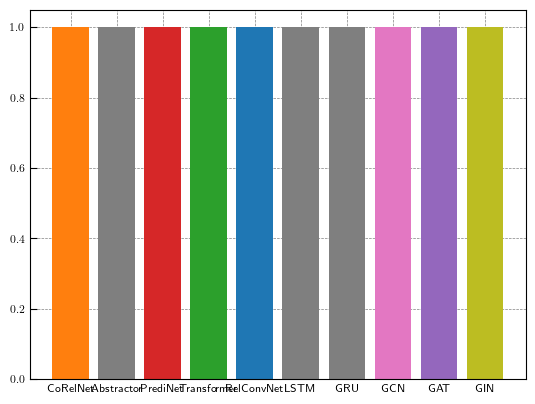

In [6]:
plt.bar(list(range(len(color_map))), 1, color=color_map.values());
plt.xticks(list(range(len(color_map))), color_map.keys());

## Relational Games

### Plots of OoD Generalization

In [7]:
results_df = pd.read_csv('figure_data/relational_games/end-of-training-accuracy.csv', index_col=0)
models = ['relconvnet', 'corelnet', 'predinet', 'transformer']
group_filter = results_df.group.isin(models)
results_df = results_df[group_filter]

results_df['group'] = pd.Categorical(results_df['group'], categories=models, ordered=True)
results_df.sort_values('group', inplace=True)
tasks = ['same', 'occurs', 'xoccurs', '1task_between', '1task_match_patt']
results_df['task'] = pd.Categorical(results_df['task'], categories=tasks, ordered=True)
results_df.sort_values(['task', 'group'], inplace=True)

results_df['group'] = results_df['group'].map(model_label_map)
results_df['task'] = results_df['task'].map(task_label_map, na_action='ignore')
results_df.rename(columns={'group': 'Model', 'task': 'Task'}, inplace=True)

In [8]:
results_df.rename(columns={'hexos_acc': 'Hexos Accuracy', 'stripes_acc': 'Stripes Accuracy'}, inplace=True)

In [9]:
results_df_hexos = results_df.copy()
results_df_hexos['Split'] = 'Hexos'
results_df_hexos['Accuracy'] = results_df_hexos['Hexos Accuracy']
results_df_hexos.drop(columns=['Hexos Accuracy', 'Stripes Accuracy', 'acc'], inplace=True)

results_df_stripes = results_df.copy()
results_df_stripes['Split'] = 'Stripes'
results_df_stripes['Accuracy'] = results_df_stripes['Stripes Accuracy']
results_df_stripes.drop(columns=['Hexos Accuracy', 'Stripes Accuracy', 'acc'], inplace=True)

results_df_ = pd.concat([results_df_hexos, results_df_stripes], axis=0)
results_df_

,Model,name,trial,Task,Split,Accuracy
44,RelConvNet,trial = 2,2,same,Hexos,0.9852
43,RelConvNet,trial = 1,1,same,Hexos,0.9924
41,RelConvNet,trial = 3,3,same,Hexos,0.9924
40,RelConvNet,trial = 4,4,same,Hexos,0.9830
42,RelConvNet,trial = 0,0,same,Hexos,0.9910
...,...,...,...,...,...,...
26,Transformer,trial = 3,3,match pattern,Stripes,0.5900
25,Transformer,trial = 4,4,match pattern,Stripes,0.5900
41,Transformer,trial = 0,0,match pattern,Stripes,0.5728
28,Transformer,trial = 1,1,match pattern,Stripes,0.5930


In [10]:
results_df_ = results_df_.groupby(['Model', 'Task', 'Split'])['Accuracy'].aggregate(['mean', 'sem', 'count']).reset_index()
results_df_['error_bar'] = results_df_['sem'] * 1.96
results_df_.rename(columns={'mean': 'Accuracy', 'sem': 'Standard Error', 'count': '# of Trials'}, inplace=True)

In [11]:
fig = px.bar(
    results_df_, x='Task', y='Accuracy', error_y='error_bar', facet_col='Split', color='Model',
    barmode='group', hover_data=['# of Trials'])
fig.update_layout(
    title="Out-of-Distribution Generalization Performance on Relational Games Tasks",
  legend=dict(yanchor="top", y=-0.2, xanchor="center", x=0.5, orientation='h'))
# remove x-axis title
for axis in fig.layout:
#     if type(fig.layout[axis]) == go.layout.YAxis:
#         fig.layout[axis].title.text = ''
    if type(fig.layout[axis]) == go.layout.XAxis:
        fig.layout[axis].title.text = ''

fig.write_html(f'{save_dir}/relational_games_ood_gen.html')
fig

In [12]:
fig_json = fig.to_json()
# save fig_json to file
with open(f'{save_dir}/relational_games_ood_gen.json', 'w') as f:
    f.write(fig_json)

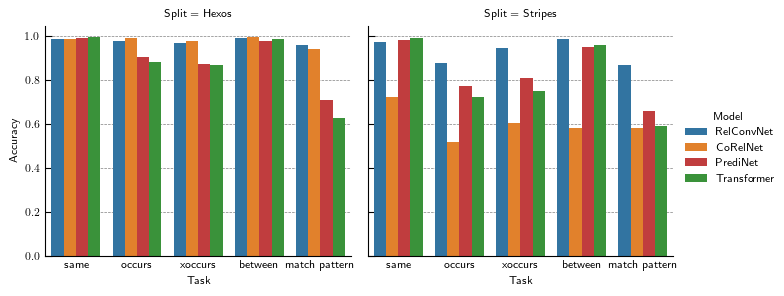

In [13]:
fig = sns.catplot(
    results_df_, kind='bar', col='Split', x='Task', y='Accuracy', hue='Model',
    sharey=True, legend='auto', legend_out=True, palette=color_map, **errbar_kwargs, height=3, aspect=1.15)
# fig.savefig(f'{save_dir}/relgames_ood_acc.pdf')

### Training curve figures

In [14]:
# run_histories = pd.read_csv('figure_data/relational_games/project_run_histories.csv', index_col=0)
# run_histories.head()

In [15]:
# tasks = ['same', 'occurs', 'xoccurs', '1task_between', '1task_match_patt']

# def get_task_run_histories(run_histories, task):
#     # task_filter
#     task_filter = run_histories.task == task
#     task_run_histories = run_histories[task_filter]

#     # model filter / sorting
#     models = ['relconvnet', 'corelnet', 'predinet', 'transformer', 'abstractor']
#     group_filter = task_run_histories.group.isin(models)
#     task_run_histories = task_run_histories[group_filter]

#     task_run_histories['group'] = pd.Categorical(task_run_histories['group'], categories=models, ordered=True)
#     task_run_histories.sort_values('group', inplace=True)
#     task_run_histories['group'] = task_run_histories['group'].map(model_label_map)
#     task_run_histories.rename(columns={'group': 'Model'}, inplace=True)

#     return task_run_histories

In [16]:
# max_batch = 2000
# step_size = 25
# batch_steps_keep = np.arange(0, max_batch + 1, step_size)

In [17]:
# model_label_map

In [18]:
# fig = plt.figure(figsize=(6.5,3))

# axes = []
# for i, task in enumerate(tasks):
#     task_run_histories = get_task_run_histories(run_histories, task)
#     batch_filter = task_run_histories['batch/batch_step'].isin(batch_steps_keep)
#     task_run_histories = task_run_histories[batch_filter]
#     task_run_histories.rename(columns={'batch/batch_step': 'batch step', 'batch/acc': 'training accuracy'}, inplace=True)
#     ax = fig.add_subplot(2, 3, i+1)
#     sns.lineplot(task_run_histories, y='training accuracy', x='batch step', hue='Model', estimator='mean', errorbar=('ci', 95), legend=False, ax=ax)
#     ax.set_title(task_label_map.get(task, task))
#     axes.append(ax)

# # NOTE legend labels are hard-coded
# fig.legend(handles=ax.get_lines(), labels=['RelConvNet', 'CoRelNet', 'PrediNet', 'Transformer'],  loc=(0.775, 0.15), title='Model')
# fig.set_tight_layout(True)
# # fig.savefig(f'{save_dir}/all_training_curves.pdf')

## Contains 'SET'

### End-of-training accuracy

In [19]:
results_df = pd.read_csv('figure_data/contains_set/end-of-training-accuracy.csv', index_col=0)
models = ['relconvnet', 'corelnet', 'predinet', 'transformer', 'gcn', 'gat', 'gin'] # 'lstm', 'gru',
group_filter = results_df.group.isin(models)
results_df = results_df[group_filter]

results_df['group'] = pd.Categorical(results_df['group'], categories=models, ordered=True)
results_df.sort_values('group', inplace=True)
results_df['group'] = results_df['group'].map(model_label_map)
results_df.rename(columns={'group': 'Model', 'acc': 'Accuracy'}, inplace=True)

In [20]:
results_df = results_df.groupby(['Model'])['Accuracy'].aggregate(['mean', 'sem', 'count']).reset_index()
results_df['error_bar'] = results_df['sem'] * 1.96
results_df.rename(columns={'mean': 'Accuracy', 'sem': 'Standard Error', 'count': '# of Trials'}, inplace=True)

In [21]:
fig = px.bar(results_df, x='Model', y='Accuracy', error_y='error_bar', hover_data=['# of Trials'], color='Model')
fig.update_layout(title="Accuracy for 'Contains SET' Task", width=1000, height=500, showlegend=False)
fig.write_html(f'{save_dir}/contains_set_acc.html')
fig

In [14]:
fig_json = fig.to_json()
# save fig_json to file
with open(f'{save_dir}/contains_set_acc.json', 'w') as f:
    f.write(fig_json)

### Training curves

In [21]:
# task_run_histories = pd.read_csv('figure_data/contains_set/run_history.csv', index_col=0)

# # model filter / sorting
# models = ['relconvnet', 'corelnet', 'predinet', 'transformer', 'abstractor']
# group_filter = task_run_histories.group.isin(models)
# task_run_histories = task_run_histories[group_filter]

# task_run_histories['group'] = pd.Categorical(task_run_histories['group'], categories=models, ordered=True)
# task_run_histories.sort_values('group', inplace=True)
# task_run_histories['group'] = task_run_histories['group'].map(model_label_map)
# task_run_histories.rename(columns={'group': 'Model'}, inplace=True)
# task_run_histories.rename(columns={'epoch/epoch': 'epoch', 'epoch/acc': 'training accuracy'}, inplace=True)
# fig, ax = plt.subplots(figsize=(3.5, 2.25))
# sns.lineplot(task_run_histories, y='training accuracy', x='epoch', hue='Model', palette=color_map, estimator='mean', errorbar=('ci', 95), ax=ax)
# fig.set_tight_layout(True)
# # fig.savefig(f'{save_dir}/contains_set_training_curves_trainacc.pdf')

In [22]:
# task_run_histories = pd.read_csv('figure_data/contains_set/run_history.csv', index_col=0)

# # model filter / sorting
# models = ['relconvnet', 'corelnet', 'predinet', 'transformer', 'abstractor']
# group_filter = task_run_histories.group.isin(models)
# task_run_histories = task_run_histories[group_filter]

# task_run_histories['group'] = pd.Categorical(task_run_histories['group'], categories=models, ordered=True)
# task_run_histories.sort_values('group', inplace=True)
# task_run_histories['group'] = task_run_histories['group'].map(model_label_map)
# task_run_histories.rename(columns={'group': 'Model'}, inplace=True)
# task_run_histories.rename(columns={'epoch/epoch': 'epoch', 'epoch/val_acc': 'validation accuracy'}, inplace=True)
# fig, ax = plt.subplots(figsize=(3.5, 2.25))
# sns.lineplot(task_run_histories, y='validation accuracy', x='epoch', palette=color_map, hue='Model', estimator='mean', errorbar=('ci', 95), ax=ax)
# fig.set_tight_layout(True)
# # fig.savefig(f'{save_dir}/contains_set_training_curves_valacc.pdf')

## Representation

In [23]:
conv_rep_df = pd.read_csv('figure_data/contains_set/set_conv_representation.csv', index_col=0)

In [24]:
fig = px.scatter(conv_rep_df, x='conv [PC1]', y='conv [PC2]', color='SET')
fig.update_layout(
    width=1000, height=500, #template='plotly_dark',
    title=dict(text="Convolutional Representation of Relations between Triplets of Objects"),
    xaxis_title=r"$\langle R[g], \boldsymbol{f} \rangle_{\mathrm{rel}} \ \text{[PC1]}$",
    yaxis_title=r"$\langle R[g], \boldsymbol{f} \rangle_{\mathrm{rel}} \ \text{[PC2]}$"
    )
fig.write_html(f'{save_dir}/contains_set_conv_rep.html')
fig

In [25]:
fig_json = fig.to_json()
with open(f'{save_dir}/contains_set_conv_rep.json', 'w') as f:
    f.write(fig_json)